# Binomial Mixture Model with Expectation-Maximization (EM) Algorithm


## Generating Data

We first generate some data points which are randomly drawn from a Binomial Mixture Model with two Binomial Distributions. Given $N_i$, the probability of $n_i$ is

$P(n_i | N_i, \Theta) = \sum_{k=1}^{2}\pi_k \mathrm{Bino}(n_i|N_i, \theta_k)$, 

where the Binomial Distribution is

$\mathrm{Bino}(n_i|N_i, \theta) = {N_i!\over n_i!(N_i-n_i)!} \theta^{n_i} (1-\theta)^{N_i-n_i}$,

and the sum of $\pi$'s is unity, i.e.

$\sum_{k=1}^{2} \pi_k = 1$

In [54]:
import numpy as np
import torch
from torch.distributions.binomial import Binomial

if torch.cuda.is_available():
    print("cuda is available")
    import torch.cuda as t
else:
    print("cuda is unavailable")
    import torch as t

cuda is unavailable


In [55]:
S = int(1e5)

# the theta's of the Binomial Distributions
theta_1 = 0.5
theta_2 = 0.3

# the probabilities, pi's, of the two Binomial Distributions
pi_1 = 0.6
pi_2 = 1e0 - pi_1

# the list of (Ni| i =1, 2, ..., S), uniformly drawn between low and high
N_ls_all = t.randint(low=10, high=20, size=(S,))
N_ls_all = N_ls_all.type(t.FloatTensor)

# the list of theta, each theta is either theta_1 or theta_2. The probability of theta_i is pi_i
theta_ls = t.FloatTensor(np.random.choice([theta_1,theta_2], size=S, p=[pi_1,pi_2]))

# the list of (ni | i=1,2 ...,S)
n_ls_all = Binomial(N_ls_all, theta_ls).sample()

Make some figures to get some visual impression of the dataset.

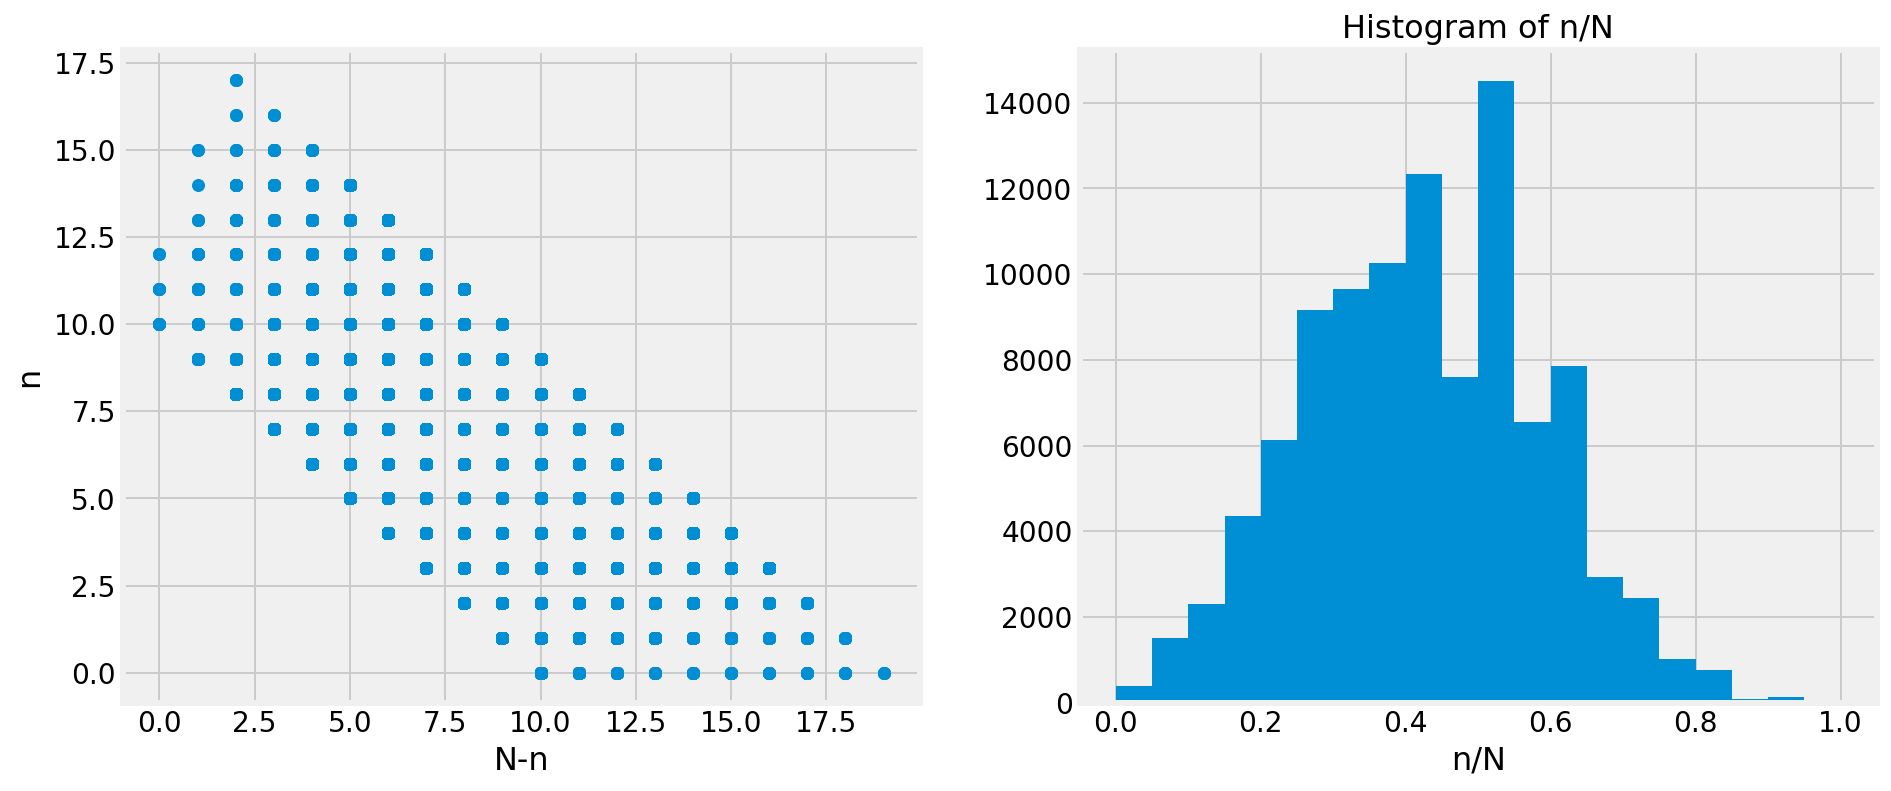

In [56]:
import matplotlib.pyplot as plt
%matplotlib inline 

fig, axes = plt.subplots(1,2,figsize=(14,6))
axes[0].scatter(N_ls_all-n_ls_all, n_ls_all)
axes[0].set_xlabel("N-n",size=16)
axes[0].set_ylabel("n",size=16)
axes[0].tick_params(labelsize=14)

axes[1].hist(n_ls_all/N_ls_all, bins=20)
axes[1].set_xlabel("n/N", size=16)
axes[1].tick_params(labelsize=14)
axes[1].set_title("Histogram of n/N", size=16)
plt.show()

We split the dataset into train and validation. 

In [57]:
# Split into train and validation sets
S = len(N_ls_all)
shuffled_indice = torch.randperm(S)
N_ls_shuffled = N_ls_all[shuffled_indice]
n_ls_shuffled = n_ls_all[shuffled_indice]

# percentage of train set.
train_frac = 0.7
train_index = int(0.7*S)
N_ls_train = N_ls_shuffled[0:train_index]
N_ls_valid = N_ls_shuffled[train_index:]
n_ls_train = n_ls_shuffled[0:train_index]
n_ls_valid = n_ls_shuffled[train_index:]

We only want to train on the training set. So we make the following assignments.

In [58]:
N_ls = N_ls_train
n_ls = n_ls_train

# Fitting the Data by Binomial Mixture Models 

The method would fit the parameters

$\Theta = \{ (\pi_k, \theta_k) | k=1, 2, ..., K\}$

We try different values for $K$. The Akaike Information Criterion (AIC) decreases as $K$ increases. We shall choose the $K$ at which the decreasing rate of AIC slows down significantly. 

AIC $= -{2\over S} \log L + {2(2K+1)\over S}$,

where $S$ is the number of samples in the dataset, $(2K+1)$ is the number of parameters in the Binomial-Mixture model, and $\log L$ is the `log_likelihood`. The `log_likelihood` is the probability of $\Theta$ given the observed data set. More details can be found in the notebook 'BMM_EM_Algorithm_fit_K_torch.ipynb' in the same github repo and my article on [medium.com](https://medium.com/@jingluan.xw/binomial-mixture-model-with-expectation-maximum-em-algorithm-feeaf0598b60). 

In [59]:
from BinomialMixture_object import BinomialMixture

# Sample size
S = len(N_ls)
S_val = len(N_ls_valid)

K_list = range(1, 5)
params_list = []

logL_list = []
AIC_list = []
BIC_list = []

logL_val_list = []
AIC_val_list = []
BIC_val_list = []

# Set K, the number of Binomial distributions in the to-be-fitted mixture model
for K in K_list:

    BM = BinomialMixture(n_components=K, tolerance=1e-6, max_step=int(5e4), verbose=False)
    BM.fit(N_ls, n_ls)
    log_likelihood = BM.calc_logL(N_ls, n_ls)
    AIC, BIC = BM.calc_AIC_BIC(N_ls, n_ls)
    pi_list = BM.pi_list
    theta_list = BM.theta_list
    params = torch.stack([pi_list, theta_list], dim=1)

    #  calculate metrics for the validation sets
    log_likelihood_val = BM.calc_logL(N_ls_valid, n_ls_valid)
    AIC_val = -2.0/float(S_val)*log_likelihood_val + 2.0*(2.0*float(K)+1.0)/float(S_val)
    BIC_val = -2.0*log_likelihood_val + np.log(float(S_val))*(2.0*float(K)+1.0)

    print(f"{params}")
    print(f"Akaike Information Criterion (AIC) = {AIC:.6f}")
    print(f"Bayesian Information Criterion (BIC) = {BIC:.6f}")

    logL_list.append(log_likelihood)
    AIC_list.append(AIC)
    BIC_list.append(BIC)
    params_list.append(params)

    logL_val_list.append(log_likelihood_val)
    AIC_val_list.append(AIC_val)
    BIC_val_list.append(BIC_val)


print(f"K = {K_list}")

print(f"logL = {logL_list}")
print(f"logL_val = {logL_val_list}")

print(f"AIC = {AIC_list}")
print(f"AIC_val = {AIC_val_list}")

print(f"BIC = {BIC_list}")
print(f"BIC_val = {BIC_val_list}")

torch.save(K_list, "K_list.pt")
torch.save(params_list, "params_list.pt")

torch.save(logL_list, "logL_list.pt")
torch.save(AIC_list, "AIC_list.pt")
torch.save(BIC_list, "BIC_list.pt")

torch.save(logL_val_list, "logL_val_list.pt")
torch.save(AIC_val_list, "AIC_val_list.pt")
torch.save(BIC_val_list, "BIC_val_list.pt")

pi_list is on device -1
pi_K is on device -1
tensor([[1.0000, 0.4205]])
Akaike Information Criterion (AIC) = 4.612195
Bayesian Information Criterion (BIC) = 322881.062500
pi_list is on device -1
pi_K is on device -1
tensor([[0.0099, 0.0678],
        [0.9901, 0.4239]])
Akaike Information Criterion (AIC) = 4.589366
Bayesian Information Criterion (BIC) = 321301.406250
pi_list is on device -1
pi_K is on device -1
tensor([[0.0072, 0.0678],
        [0.0027, 0.0678],
        [0.9901, 0.4239]])
Akaike Information Criterion (AIC) = 4.589425
Bayesian Information Criterion (BIC) = 321323.843750
pi_list is on device -1
pi_K is on device -1
tensor([[0.0035, 0.0678],
        [0.0013, 0.0678],
        [0.0051, 0.0678],
        [0.9901, 0.4239]])
Akaike Information Criterion (AIC) = 4.589481
Bayesian Information Criterion (BIC) = 321346.093750
K = range(1, 5)
logL = [tensor(-161423.7969), tensor(-160622.8125), tensor(-160622.8750), tensor(-160622.8438)]
logL_val = [tensor(-69176.1172), tensor(-68841.5

Plot AIC as a function of $K$.

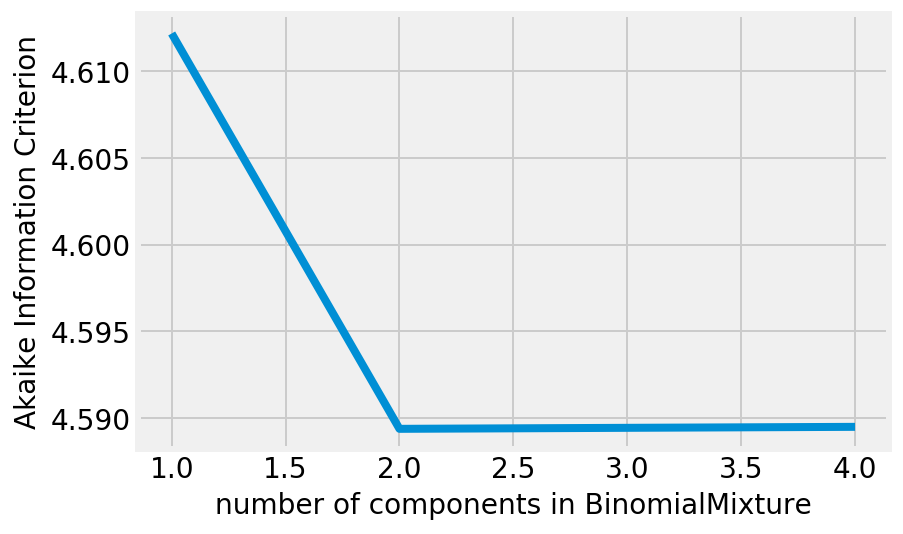

In [60]:
K_list = torch.load("K_list.pt")
params_list = torch.load("params_list.pt", map_location=torch.device('cpu'))

logL_list = torch.load("logL_list.pt", map_location=torch.device('cpu'))
AIC_list = torch.load("AIC_list.pt", map_location=torch.device('cpu'))
BIC_list = torch.load("BIC_list.pt", map_location=torch.device('cpu'))

logL_val_list = torch.load("logL_val_list.pt", map_location=torch.device('cpu'))
AIC_val_list = torch.load("AIC_val_list.pt", map_location=torch.device('cpu'))
BIC_val_list = torch.load("BIC_val_list.pt", map_location=torch.device('cpu'))

import matplotlib.pyplot as plt
import matplotlib.style as style
style.use('fivethirtyeight')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.plot(K_list, AIC_list)
plt.yticks(size=14)
plt.xticks(size=14)
plt.xlabel("number of components in BinomialMixture", size=14)
plt.ylabel("Akaike Information Criterion", size=14)
plt.show()

At $K=2$, the decreasing rate of AIC slows down significantly. So we choose $K=2$. The corresponding paramters are listed below.

In [62]:
print(f"The pi's are {params_list[1][:,0]}")
print(f"The theta's are {params_list[1][:,1]}")

The pi's are tensor([0.0099, 0.9901])
The theta's are tensor([0.0678, 0.4239])
